# Solve Wave Equation with PINN

## Defining the Wave Equation

The wave equation in 1D is given by:
$$
\frac{\partial^2u}{\partial t^2}=c^2\frac{\partial^2u}{\partial x^2}
$$

where $u(x,t)$ is the wave function, $c$ is the wave speed and $x$ is the spatial coordinate, and $t$ is the time.

## Library Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2024-05-21 14:10:59.515782: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 14:10:59.551871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 14:11:00.158353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Generate Training Data
We need both the initial/boundary conditions data and collocation points for the PDE. Assuming a simple ase where the theoretical solution is 
$$
u(x,t)=sin(\pi x)cos(\pi t)
$$

In [2]:
def generate_data(X,T):
    # # Example initial and boundary conditions (can be adjusted)
    # u0 = np.sin(np.pi * X[0, :])
    # u1 = np.zeros_like(X[0, :])
    
    x_train = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_train = np.sin(np.pi * X.flatten()[:, None]) * np.cos(np.pi * T.flatten()[:, None])
    
    return x_train, u_train

x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
x_train, u_train = generate_data(X,T)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
u_train = tf.convert_to_tensor(u_train, dtype=tf.float32)

2024-05-21 14:11:01.936818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6536 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:65:00.0, compute capability: 7.5


Text(0, 0.5, 't')

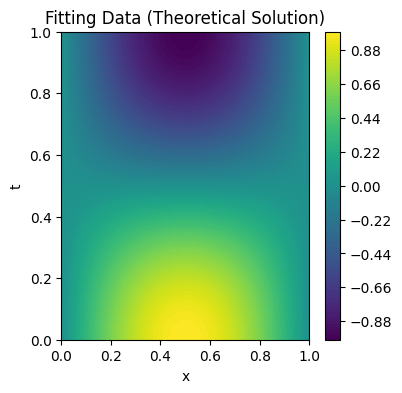

In [3]:
# Plotting
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

# Theoretical plot
c1 = axs.contourf(X, T, u_train.numpy().reshape(X.shape), levels=100, cmap='viridis')
fig.colorbar(c1, ax=axs)
axs.set_title('Fitting Data (Theoretical Solution)')
axs.set_xlabel('x')
axs.set_ylabel('t')


## Neural Network Setup
- Input: $(x,t)$
- Output: $u(x,t)$

In [4]:
def create_model():
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(2,))) # (x,t)
    model.add(layers.Dense(20, activation='tanh'))
    model.add(layers.Dense(20, activation='tanh'))
    model.add(layers.Dense(20, activation='tanh'))
    model.add(layers.Dense(1, activation=None))  # Output u(x, t)
    return model

model = create_model()

/home/jackyko/mambaforge/envs/pyhisto/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Plug the data input and output to the PINN model

In [5]:
u_pred = model(x_train)

## Defining Physics Informed Loss Function

The loss function includes both the data loss and the PDE residual loss.
$$
L_\text{PINN} = L_\text{2,Data} + L_\text{2,Residual}
$$

### PDE Residual Loss
Mean squared error of the PDE residual.
Using automatic differentiation to compute the required derivatives:
$$
L_\text{Residual} = \frac{\partial^2u}{\partial t^2}-c^2\frac{\partial^2u}{\partial x^2}
$$

In [6]:
def wave_eq_residual(u, x, t, c=1.0):
    u_t = tf.gradients(u, t)[0]
    u_tt = tf.gradients(u_t, t)[0]
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    residual = u_tt - c**2 * u_xx
    return residual

### PINN Loss


In [7]:
def physics_informed_loss(model, x, t, u_true, c=1.0):
    u_pred = model(tf.concat([x, t], axis=1))
    residual = wave_eq_residual(u_pred, x, t, c)
    data_loss = tf.reduce_mean(tf.square(u_pred - u_true))
    pde_loss = tf.reduce_mean(tf.square(residual))
    return data_loss + pde_loss

## Training

Train the neural network to minimize the combined loss function using gradient descent.

In [8]:
optimizer = Adam(learning_rate=1e-3)

In [9]:
@tf.function
def train_step(x, t, u_true):
    with tf.GradientTape() as tape:
        loss = physics_informed_loss(model, x, t, u_true)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [10]:
epochs = 2000
loss_values = []
for epoch in range(epochs):
    loss_value = train_step(x_train[:, 0:1], x_train[:, 1:2], u_train)
    loss_values.append(loss_value)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

Epoch 0, Loss: 0.3581039011478424
Epoch 100, Loss: 0.05081867426633835
Epoch 200, Loss: 0.04599619284272194
Epoch 300, Loss: 0.039925381541252136
Epoch 400, Loss: 0.029470061883330345
Epoch 500, Loss: 0.02554992586374283
Epoch 600, Loss: 0.024319235235452652
Epoch 700, Loss: 0.02174263820052147
Epoch 800, Loss: 0.013166526332497597
Epoch 900, Loss: 0.00596556207165122
Epoch 1000, Loss: 0.0038735128473490477
Epoch 1100, Loss: 0.0031522237695753574
Epoch 1200, Loss: 0.002833030419424176
Epoch 1300, Loss: 0.00264351605437696
Epoch 1400, Loss: 0.0024134947452694178
Epoch 1500, Loss: 0.0022510746493935585
Epoch 1600, Loss: 0.002099958946928382
Epoch 1700, Loss: 0.001967768417671323
Epoch 1800, Loss: 0.0018472166266292334
Epoch 1900, Loss: 0.0017319744220003486


(0.0, 2098.95)

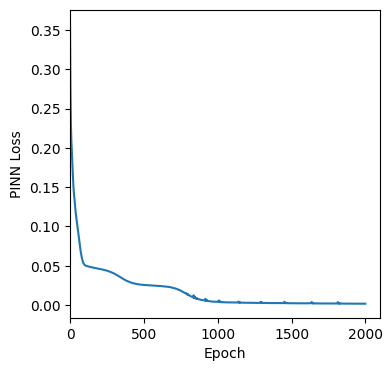

In [11]:
fig, axs = plt.subplots(1,1,figsize=(4,4))
axs.plot(np.arange(epochs),loss_values)
axs.set_xlabel("Epoch")
axs.set_ylabel("PINN Loss")
axs.set_xlim(left=0)

## Compare PINN and Theoretical Solutions

In [12]:
# PINN predictions
u_pinn = model(x_train,)
u_pinn = u_pinn.numpy().reshape(X.shape)

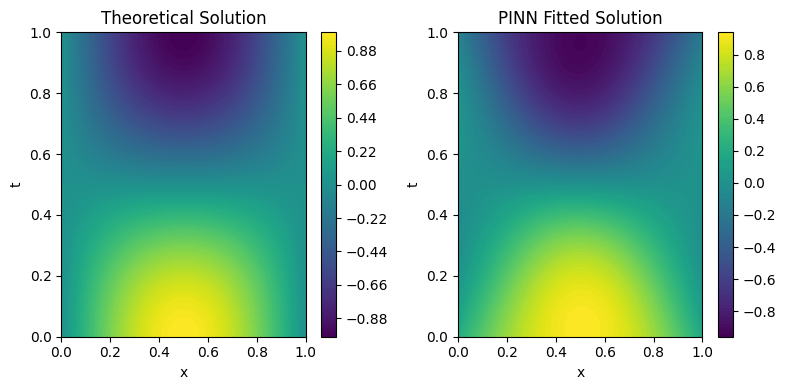

In [13]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Theoretical plot
c1 = axes[0].contourf(X, T, u_train.numpy().reshape(X.shape), levels=100, cmap='viridis')
fig.colorbar(c1, ax=axes[0])
axes[0].set_title('Theoretical Solution')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')

# PINN plot
c2 = axes[1].contourf(X, T, u_pinn, levels=100, cmap='viridis')
fig.colorbar(c2, ax=axes[1])
axes[1].set_title('PINN Fitted Solution')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')

plt.tight_layout()
plt.show()